### Tutorial for Bayesian Optimization:


Source: Practical Bayesian Optimization of Machine Learning Algorithms

Link: https://papers.nips.cc/paper/4522-practical-bayesian-optimization-of-machine-learning-algorithms.pdf


In [15]:
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision.datasets as dset
import torchvision.transforms as transforms

# Our imports 
from gp import GP, SquaredExp, Matern52
import sampling as s


sns.set_palette('muted',color_codes=True)
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Example with deep learning
* Right now we do just external hp's but we could do internal if we were feeling frisky
* e.g. optimize number of layers and width of layers 

In [2]:
####################### GLOBALS #########################
# To use GPU's or not to use GPU's?
use_cuda = torch.cuda.is_available()

# Get mnist data - Note: if this fails switch download to True
train_set = dset.MNIST(root='../data', train=True, transform=transforms.ToTensor(), download=False)
test_set = dset.MNIST(root='../data', train=False, transform=transforms.ToTensor())

# Get the x and y tensors from test for quick evaluation 
test_loader = torch.utils.data.DataLoader(dataset=test_set, batch_size=len(test_set), shuffle=False)
for test_x, test_y in test_loader:
    test_x = Variable(test_x,volatile=True) if not use_cuda else Variable(test_x.cuda(),volatile=True)
    test_y = Variable(test_y,volatile=True) if not use_cuda else Variable(test_y.cuda(),volatile=True)
    
##########################################################
    
# Define the CNN we will be working with 
class CNN(nn.Module):
    """ CNN for MNIST """
    def __init__(self):
        super(CNN,self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = x.view(-1,1,28,28)
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x,dim=1)

def train(model, opt, lossf, data_loader, epochs, use_cuda=False):
    """ Simple function to train a PyTorch model """
    for e in range(epochs):
        for bx,by in data_loader:
            bx = Variable(bx) if not use_cuda else Variable(bx.cuda())
            by = Variable(by) if not use_cuda else Variable(by.cuda())
            opt.zero_grad()
            
            result = model(bx)
            loss = lossf(result,by)
            
            loss.backward()
            opt.step()

            
def torch_try_hp(hps):
    """ Function to try different hyperparameters and return the validation set loss """
    # Types need to be: int, float, int, float
    bs, lr, epochs, reg = hps.ravel()
    
    # Set training loaders 
    train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=int(bs), shuffle=True)
    
    # Initialize model 
    model = CNN() if not use_cuda else CNN().cuda()
    opt = optim.SGD(model.parameters(), lr=lr, weight_decay=reg, momentum=0.9)
    loss_func = nn.NLLLoss()
    train(model, opt, loss_func, train_loader, epochs=int(epochs), use_cuda=use_cuda)
    
    # Get test loss
    test_result = model(test_x)
    test_loss = loss_func(test_result, test_y)
    test_loss = test_loss.data.numpy() if not use_cuda else test_loss.data.cpu().numpy()
    
    return test_loss[0]
    

### Bayesian optimization over hyperparameters of a CNN 

* Note: do not rerun this unless you have a GPU and plenty of time to spare.

In [3]:
# Get some initial points 
hps_x = np.array([[32.0, 0.001, 10.0, 0],
                  [64.0, 0.01, 10.0, 0],
                  [128.0, 0.001, 5.0, 0]])
hps_y = np.zeros(3)
    
for i,hp in enumerate(hps_x):
    print(hp)
    test_loss = torch_try_hp(hp)
    hps_y[i] = test_loss
    

[3.2e+01 1.0e-03 1.0e+01 0.0e+00]
[6.4e+01 1.0e-02 1.0e+01 0.0e+00]
[1.28e+02 1.00e-03 5.00e+00 0.00e+00]


In [ ]:
# this seems to take a really long amount of time 

In [4]:
hps_x, hps_y

(array([[3.20e+01, 1.00e-03, 1.00e+01, 0.00e+00],
        [6.40e+01, 1.00e-02, 1.00e+01, 0.00e+00],
        [1.28e+02, 1.00e-03, 5.00e+00, 0.00e+00]]),
 array([0.1048172 , 0.05843832, 0.31420225]))

In [5]:
# Make the GP instance 
mnist_gp = GP(hps_x, hps_y, Matern52)

# Propose points 
batch_sizes = np.arange(32,256,32)
learning_rates = np.linspace(.001,.5,20)
epochs = np.arange(2,40,10)
reg_params = np.linspace(0,0,1)

# Make the mesh 
mnist_mesh = np.meshgrid(batch_sizes, learning_rates, epochs, reg_params)
mnist_prop = np.array(mnist_mesh).T.reshape(-1,len(mnist_mesh))
print(mnist_prop.shape)

(560, 4)


In [6]:
batch_sizes, learning_rates, epochs, reg_params

(array([ 32,  64,  96, 128, 160, 192, 224]),
 array([0.001     , 0.02726316, 0.05352632, 0.07978947, 0.10605263,
        0.13231579, 0.15857895, 0.18484211, 0.21110526, 0.23736842,
        0.26363158, 0.28989474, 0.31615789, 0.34242105, 0.36868421,
        0.39494737, 0.42121053, 0.44747368, 0.47373684, 0.5       ]),
 array([ 2, 12, 22, 32]),
 array([0.]))

In [ ]:
# i don't understand how we are saving on ime here ... are we going through every option 
# why do we have to pass in all of this? 

In [7]:
# Do the bayesian optimization
best_res_mnist, mnist_hist = mnist_gp.find_best(torch_try_hp, mnist_prop, iters=5)

100%|██████████| 5/5 [1:11:37<00:00, 859.43s/it]


In [8]:
batch_size, lr, epochs, reg_par = min(mnist_hist,key=lambda x: x[1])[0][0]
print(f'We acheived best performance of loss = {min(mnist_hist,key=lambda x: x[1])[1][0][0]}')
print(f'Parameters were batch = {batch_size}, lr= {round(lr,4)}, epochs = {epochs}, and reg param = {reg_par}')

We acheived best performance of loss = 0.07656645029783249
Parameters were batch = 96.0, lr= 0.001, epochs = 32.0, and reg param = 0.0


In [25]:
params_tried = np.array([m[0][0] for m in mnist_hist])
losses_recorded = np.array([m[1][0] for m in mnist_hist])

x = params_tried[:,0]
y = params_tried[:,1]
z = params_tried[:,2]
losses = losses_recorded.reshape(-1)

(array([192., 224.,  96., 160.,  96.]),
 array([0.001, 0.001, 0.001, 0.001, 0.001]),
 array([ 2., 12.,  2., 12., 32.]))

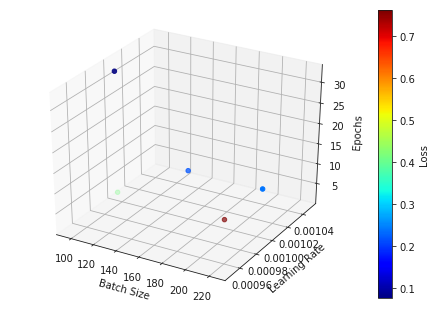

In [28]:
import matplotlib.cm as cmx
from mpl_toolkits.mplot3d import Axes3D

def scatter3d(x,y,z, cs, colorsMap='jet'):
    cm = plt.get_cmap(colorsMap)
    cNorm = matplotlib.colors.Normalize(vmin=min(cs), vmax=max(cs))
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cm)
    fig = plt.figure()
    ax = Axes3D(fig)
    ax.scatter(x, y, z, c=scalarMap.to_rgba(cs))
    ax.set_xlabel('Batch Size')
    ax.set_ylabel('Learning Rate')
    ax.set_zlabel('Epochs')
    scalarMap.set_array(cs)
    fig.colorbar(scalarMap,label='Loss')
    plt.show()

scatter3d(x,y,z,losses)

In [43]:
# Now lets put it to use
use_cuda = torch.cuda.is_available()

# Set training loader
train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=int(batch_size), shuffle=True)
    
# Initialize model 
model = CNN() if not use_cuda else CNN().cuda()
opt = optim.SGD(model.parameters(), lr=lr, weight_decay=reg_par, momentum=0.9)
loss_func = nn.NLLLoss()
train(model, opt, loss_func, train_loader, epochs=int(epochs), use_cuda=use_cuda)

print('Training done. Model ready!')

Training done. Model ready!


In [44]:
# Accuracy measures
def accuracy(model,x,y,use_cuda=False):
    """ Get classification accuracy for a torch model (or any function that can take
    torch Variables as input).
    ---------
    Args: model; a torch model, or any function that can take torch Variable inputs
          x; torch Tensor object to be made into a Variable before running through
                model.
          y; torch Tensor with outputs of classification for comparison with model(x)
    ---------
    Returns: float; the classification accuracy of the model.
    """
    if use_cuda:
        probs = model(Variable(x.cuda(),volatile=True))
        _,ypred = torch.max(probs,1)
        return (ypred.data.cpu().numpy()==y.cpu().numpy()).sum()/len(y)
    else:
        probs = model(Variable(x, volatile=True))
        _,ypred = torch.max(probs,1)
        return (ypred.data.numpy()==y.numpy()).sum()/len(y)
    
train_load_acc = torch.utils.data.DataLoader(dataset=train_set, batch_size=len(train_set), shuffle=False)
for x,y in train_load_acc:
    print('Train accuracy:',accuracy(model,x,y,use_cuda))

test_loader = torch.utils.data.DataLoader(dataset=test_set, batch_size=len(test_set), shuffle=False)
for x,y in test_loader:
    print('Test accuracy: ',accuracy(model,x,y,use_cuda))

Train accuracy: 0.9899
Test accuracy:  0.9837


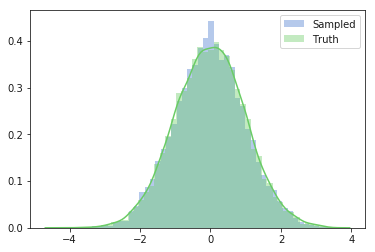

In [41]:
### TEST FOR SLICE SAMPLING ###
import scipy.stats as ss
from scipy.special import kl_div
import sampling as s

np.random.seed(999)
nsamps=10000
trace = np.zeros(nsamps)

res = 0.0
for i in range(nsamps):
    res = s.slice(ss.norm.logpdf,[res])
    trace[i] = res
    
true_norm = np.random.normal(size=10000)
sns.distplot(trace,label='Sampled',kde=False,norm_hist=True)
sns.distplot(true_norm,label='Truth')
plt.legend()

assert(np.isclose(trace.mean(),true_norm.mean(),atol=1e-1))
assert(np.isclose(trace.std(),true_norm.std(),atol=1e-2))